In [3]:
import os
import csv
import numpy as np
import pandas as pd

import scipy
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso, LinearRegression
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestRegressor,
                              GradientBoostingRegressor)
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", 999)


sns.set_palette('husl')
sns.set_style("white")

In [2]:
listings=pd.read_csv('/Users/elianezanlorense/Documents/Cog/listings.csv')
listings.head(2)

/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20200318205910,2020-03-19,Very Nice 2Br - Copacabana - WiFi,Pls note that special rates apply for Carnival...,- large balcony which looks out on pedestrian ...,Pls note that special rates apply for Carnival...,none,This is the best spot in Rio. Everything happe...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,2.12
1,21280,https://www.airbnb.com/rooms/21280,20200318205910,2020-03-19,Renovated Modern Apt. Near Beach,Immaculately renovated top-floor apartment ove...,Immaculately renovated top-floor apartment in ...,Immaculately renovated top-floor apartment ove...,none,This is the best neighborhood in Zona Sul. Fo...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.25


Variaveis como listing_url, scrape,
Reviews: sao informacoes coletadas apos ser host
Informacoes relacionadas a localizacao, sabemos que e uma pra uma determinada cidade.
Tão informacoes nao serao consideradas.

__Step 1:__
Verificar a quantidade de missing nas variaveis

In [4]:
total = listings.isnull().sum().sort_values(ascending=False)
percent = (listings.isnull().sum())/listings.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(150)

,Total,Percent
jurisdiction_names,36085,1.000000
medium_url,36085,1.000000
thumbnail_url,36085,1.000000
xl_picture_url,36085,1.000000
neighbourhood_group_cleansed,36085,1.000000
license,36083,0.999945
square_feet,35616,0.987003
weekly_price,33674,0.933186
monthly_price,33389,0.925288
notes,24306,0.673576


__Step 2:__
Variaveis com mais de 40% de missing serao dropadas,exceto security_deposit que veremos o comportamento entre o preco e taxa.
Para as variaveis bathrooms, bedrooms and beds sera preenchido com a mediana  
Para host_identity_verified valores nullos serao dropados
Serao mantidas as seguintes variaveis[keep], as demais serao dropadas

In [5]:
keep=[

#host informations
'host_has_profile_pic',
'host_identity_verified',
'host_id' ,  
'host_verifications',    
#guest informations
'require_guest_phone_verification',
'require_guest_profile_picture',
'instant_bookable',

#location
'neighbourhood_cleansed',
'latitude',
'longitude',
 
#informations about the rules
#'security_deposit',
#'cleaning_fee',
'cancellation_policy',
'price',
'minimum_nights',
'maximum_nights',
'guests_included',
'instant_bookable',
'extra_people',
 
#informations about the place
'bathrooms',
'beds',
'bedrooms',
'bed_type',
'property_type',
'amenities',
'room_type',  
'accommodates',
'square_feet',    
]

In [6]:
listings=listings[keep]

In [7]:
listings['bathrooms'] = listings['bathrooms'].fillna(listings['bathrooms'].mode()[0])
listings['bedrooms'] = listings['bedrooms'].fillna(listings['bedrooms'].mode()[0])
listings['beds'] = listings['beds'].fillna(listings['beds'].mode()[0])
#listings['cleaning_fee_n'] = listings['cleaning_fee'].fillna(listings['cleaning_fee'].mode()[0])
#listings['security_deposit_n'] = listings['security_deposit'].fillna(listings['security_deposit'].mode()[0])

__Step 3:__
Verificar o tipo das variaveis

In [8]:
listings.dtypes

host_has_profile_pic                 object
host_identity_verified               object
host_id                               int64
host_verifications                   object
require_guest_phone_verification     object
require_guest_profile_picture        object
instant_bookable                     object
neighbourhood_cleansed               object
latitude                            float64
longitude                           float64
cancellation_policy                  object
price                                object
minimum_nights                        int64
maximum_nights                        int64
guests_included                       int64
instant_bookable                     object
extra_people                         object
bathrooms                           float64
beds                                float64
bedrooms                            float64
bed_type                             object
property_type                        object
amenities                       

__Step 4:__
Após verificar o tipo das variaveis, observa-se que variaveis que deveriam ser float, estao como objetc, e variaveis que deveriam ser int estao como float.
Neste passo, será feita esta correcao para as variaveis float e tbm int

In [9]:
listings['price_x'] = listings['price'].astype(str)
listings['price'] = listings['price_x'].str.replace("[$, ]", "").astype("float")
#listings['security_deposit_n'] = pd.to_numeric(listings['security_deposit_n'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['security_deposit_n'] = pd.to_numeric(listings['security_deposit_n'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['cleaning_fee'] = pd.to_numeric(listings['cleaning_fee'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
listings['extra_people'] = pd.to_numeric(listings['extra_people'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['cleaning_fee_n'] = pd.to_numeric(listings['cleaning_fee_n'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
listings['bathrooms'] = listings['bathrooms'].astype("int64")
listings['beds'] = listings['beds'].astype("int64")
listings['bedrooms'] = listings['bedrooms'].astype("int64")

__Verificando outliers e inconsistencias__

__Step 5:__
Verificar a distribuicao das das variaveis

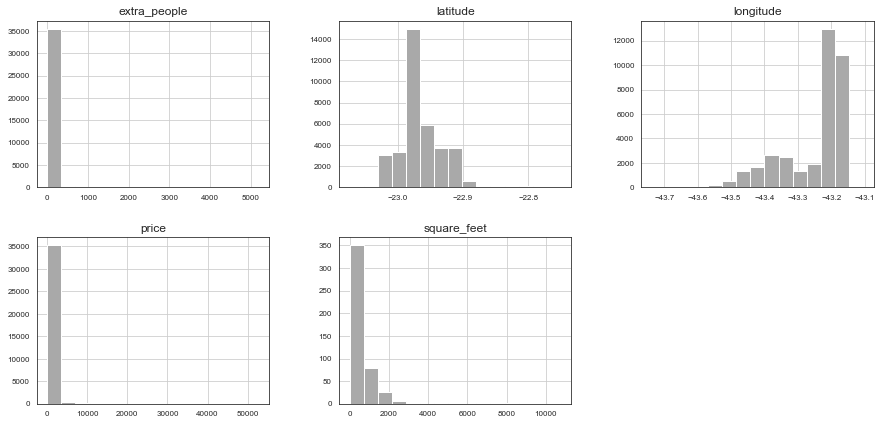

In [10]:

numerical=listings.select_dtypes(include='float64').columns.tolist()
listings[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, color='darkgrey', ylabelsize=8);

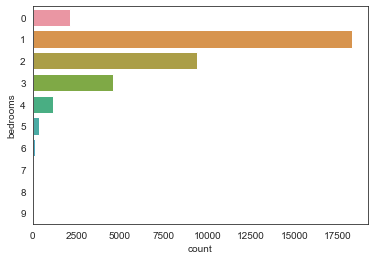

In [11]:
sns.countplot(y = 'bedrooms', data = listings,
              order = listings['bedrooms'].iloc[:10].index)  

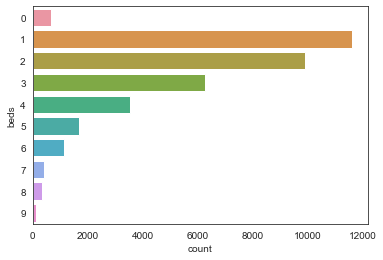

In [12]:
sns.countplot(y = 'beds', data = listings,
              order = listings['beds'].iloc[:10].index)    

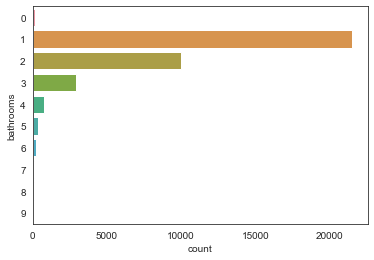

In [13]:
sns.countplot(y = 'bathrooms', data = listings,
              order = listings['bathrooms'].iloc[:10].index)  

In [14]:
cols = ['property_type']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,property_type
Apartment,27604
House,3665
Condominium,2180
Loft,710
Serviced apartment,654
Guest suite,232
Bed and breakfast,160
Guesthouse,136
Villa,112
Hotel,111


In [15]:
cols = ['cancellation_policy']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,cancellation_policy
flexible,14667
strict_14_with_grace_period,14399
moderate,6490
super_strict_60,407
super_strict_30,119
strict,3


In [16]:
cols = ['accommodates']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,accommodates
4,9474
2,9042
6,4868
3,3740
5,3006
1,1849
8,1471
7,864
10,757
12,269


In [17]:
cols = ['bed_type']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,bed_type
Real Bed,35658
Pull-out Sofa,290
Futon,66
Airbed,53
Couch,18


In [18]:
cols = ['room_type']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,room_type
Entire home/apt,25838
Private room,9264
Shared room,805
Hotel room,178


In [19]:
cols = ['host_has_profile_pic','require_guest_phone_verification','require_guest_profile_picture']
listings[cols].apply(pd.Series.value_counts)

,host_has_profile_pic,require_guest_phone_verification,require_guest_profile_picture
f,135,35516,35535
t,35939,569,550


In [20]:
cols = ['neighbourhood_cleansed']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,neighbourhood_cleansed
Copacabana,9514
Barra da Tijuca,4009
Ipanema,3099
Jacarepaguá,2033
Botafogo,1772
Recreio dos Bandeirantes,1697
Leblon,1647
Santa Teresa,1189
Centro,995
Flamengo,930


__Step 6:__
Observando o graficos acima, especialmente na variável preco (histograma), que é nosso target, nota-se que os precos estao concentrados e ha indicois de valores outliers, para tomar algum tipo de decisao, será analisado a distriuicao e também um grafico boxplot.
Variaveis categoricas com pouca volumetria serao agrupadas

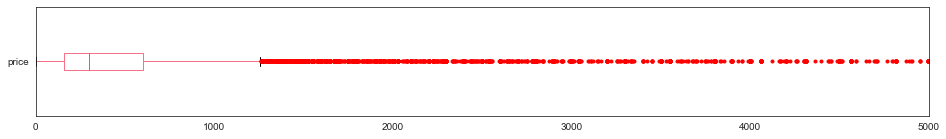

In [21]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings['price'].plot(kind='box', xlim=(0, 5000), vert=False, flierprops=red_square, figsize=(16,2))

In [22]:
listings['price'].describe()

count    36085.000000
mean       683.304115
std       1922.401326
min          0.000000
25%        157.000000
50%        299.000000
75%        599.000000
max      52763.000000
Name: price, dtype: float64

__Step 7:__
O coeficente de variacao, cv aprox. 2.14 indica grande variabilidade dos dados, e pelo boxplot nota-se
a presenca de outliers.
Para o tratamentode outliers sera aplicado o interva-los interquartilicos.

In [70]:
distance = 1.5 * (np.nanpercentile(listings['price'], 75) - np.nanpercentile(listings['price'], 25))
lim_sup=distance + np.nanpercentile(listings['price'], 75)

In [89]:
listings=clean_data
listings.drop(listings[ (listings.price == 0) | (listings.price > lim_sup)].index, axis=0, inplace=True)

In [90]:
listings['price'].describe()

count    31365.000000
mean       351.181667
std        274.952070
min         30.000000
25%        152.000000
50%        249.000000
75%        491.000000
max       1258.000000
Name: price, dtype: float64

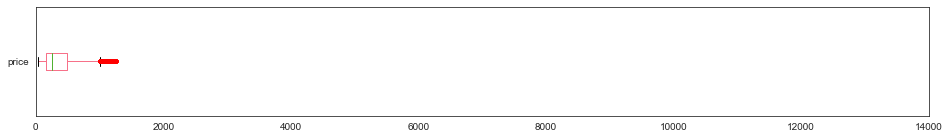

In [91]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings['price'].plot(kind='box', xlim=(0,14002), vert=False, flierprops=red_square, figsize=(16,2))

In [92]:
listings.drop(listings[ (listings.beds ==0)  ].index, axis=0, inplace=True)
listings.drop(listings[ (listings.bathrooms ==0)  ].index, axis=0, inplace=True)
listings.dropna(subset=['host_has_profile_pic'])

,host_has_profile_pic,host_identity_verified,host_id,host_verifications,require_guest_phone_verification,require_guest_profile_picture,instant_bookable,neighbourhood_cleansed,latitude,longitude,...,bathrooms,beds,bedrooms,bed_type,property_type,amenities,room_type,accommodates,square_feet,price_x
0,t,t,68997,"['email', 'phone', 'reviews', 'jumio', 'offlin...",f,f,t,Copacabana,-22.965920,-43.178960,...,1,2,2,Real Bed,Condominium,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Entire home/apt,5,NaN,$289.00
1,t,t,81163,"['email', 'phone', 'reviews', 'kba']",f,f,f,Ipanema,-22.984670,-43.196110,...,2,4,2,Real Bed,Apartment,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Entire home/apt,6,NaN,$406.00
2,t,t,102840,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,f,Copacabana,-22.977120,-43.190450,...,1,2,1,Real Bed,Apartment,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Entire home/apt,2,NaN,$162.00
3,t,t,135635,"['email', 'phone', 'manual_online', 'facebook'...",f,f,t,Ipanema,-22.983020,-43.214270,...,1,1,1,Real Bed,Apartment,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Entire home/apt,3,NaN,$330.00
4,t,t,153232,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,f,Ipanema,-22.988160,-43.193590,...,1,1,1,Real Bed,Apartment,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Entire home/apt,2,NaN,$457.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36080,t,f,341948314,"['email', 'phone']",f,f,t,Copacabana,-22.967927,-43.182624,...,1,2,2,Real Bed,Apartment,"{TV,Wifi,""Air conditioning"",Kitchen,""Smoking a...",Entire home/apt,3,NaN,$350.00
36081,t,f,4360566,"['email', 'phone', 'facebook', 'reviews', 'jum...",f,f,t,Ipanema,-22.981928,-43.201021,...,1,2,1,Real Bed,Apartment,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Entire home/apt,4,NaN,$299.00
36082,t,f,310504737,"['phone', 'jumio', 'offline_government_id', 's...",f,f,t,Leme,-22.963219,-43.171153,...,1,1,1,Real Bed,Apartment,"{TV,Wifi,""Air conditioning"",Kitchen,""Smoking a...",Entire home/apt,3,NaN,$152.00
36083,t,f,310504737,"['phone', 'jumio', 'offline_government_id', 's...",f,f,t,Leme,-22.963219,-43.171153,...,1,1,1,Real Bed,Apartment,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",Entire home/apt,3,NaN,$152.00


Para tratamento de outliers, foi removido baseado no intervalo interquartilico.
Analisamos algumas inconsistencias, como cama e banheiros zeradas, em relacao a quarto zerado obseva-se
este valores quando o tipo de propriedade é studio.

In [93]:
print("O dataset tem {} linhas e {} colunas - depois de preprocesso.".format(*listings.shape))

O dataset tem 31365 linhas e 27 colunas - depois de preprocesso.


__Construcao de novas variaveis e agrupamento de categorias com baixa volumetria__


__Step 8:__
   Variaveis como bairro, onde contem muitas categorias, sera mantida as 10 primeiras mais relevantes e as demais agrupadas.
  Serao criadas variavies, baseadas em amenities e host_verifications

In [94]:
def set_neib(row):
    if row['neighbourhood_cleansed'] in ['Copacabana']:
        return 'Copacabana'
    elif row['neighbourhood_cleansed'] in ['Barra da Tijuca']:
        return 'Barra da Tijuca'
    elif row['neighbourhood_cleansed'] in ['Ipanema']:
        return 'Ipanema'
    elif row['neighbourhood_cleansed'] in ['Botafogo']:
        return 'Botafogo'
    elif row['neighbourhood_cleansed'] in ['Jacarepaguá']:
        return 'Jacarepaguá'
    elif row['neighbourhood_cleansed'] in ['Recreio dos Bandeirantes']:
        return 'Recreio dos Bandeirantes'
    elif row['neighbourhood_cleansed'] in ['Leblon']:
        return 'Leblon'
    elif row['neighbourhood_cleansed'] in ['Santa Teresa']:
        return 'Santa Teresa'
    elif row['neighbourhood_cleansed'] in ['Centro']:
        return 'Centro'
    elif row['neighbourhood_cleansed'] in ['Flamengo']:
        return 'Flamengo'
    else:
        return 'Outros'

listings=listings.assign(New_nei=listings.apply(set_neib, axis=1))

In [95]:
listings['cancellation_policy']=listings['cancellation_policy'].replace('super_strict_60','strict')
listings['cancellation_policy']=listings['cancellation_policy'].replace('super_strict_30','strict')
listings['cancellation_policy']=listings['cancellation_policy'].replace('strict_14_with_grace_period','strict')

In [96]:
cols = ['New_nei']
listings[cols].apply(pd.Series.value_counts)

,New_nei
Copacabana,8649
Outros,7992
Barra da Tijuca,3107
Ipanema,2673
Jacarepaguá,1699
Botafogo,1634
Recreio dos Bandeirantes,1387
Leblon,1348
Santa Teresa,1082
Centro,943


In [97]:
listings['bed_type_n']=np.where((listings.bed_type == 'Real Bed') ,1,0)
listings['room_type']=listings['room_type'].replace('Hotel room','Private room')


In [98]:
results = Counter()
listings['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Kitchen', 28647),
 ('Wifi', 27916),
 ('Essentials', 26564),
 ('TV', 25655),
 ('Air conditioning', 24608),
 ('Elevator', 21577),
 ('Hangers', 21309),
 ('Washer', 20359),
 ('Iron', 20054),
 ('Laptop friendly workspace', 17746),
 ('Hot water', 15669),
 ('Family/kid friendly', 12664),
 ('Hair dryer', 12151),
 ('Dishes and silverware', 12143),
 ('Cable TV', 12115),
 ('Refrigerator', 11606),
 ('Smoking allowed', 11302),
 ('Free parking on premises', 11145),
 ('Microwave', 10378),
 ('Stove', 10168),
 ('Lock on bedroom door', 9784),
 ('Cooking basics', 9718),
 ('Bed linens', 9581),
 ('Coffee maker', 8886),
 ('Doorman', 8776),
 ('Buzzer/wireless intercom', 8723),
 ('Oven', 8605),
 ('Shampoo', 8401),
 ('Internet', 8261),
 ('Fire extinguisher', 8051)]

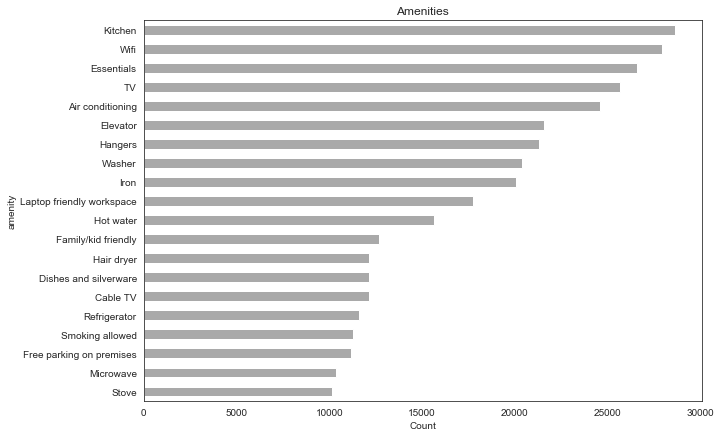

In [99]:
sub_df = pd.DataFrame(results.most_common(20), columns=['amenity', 'count'])
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [100]:
listings['Laptop_friendly_workspace'] = listings['amenities'].str.contains('Laptop friendly workspace')
listings['TV'] = listings['amenities'].str.contains('TV')
listings['Family_kid_friendly'] = listings['amenities'].str.contains('Family/kid friendly')
listings['Smoking_allowed'] = listings['amenities'].str.contains('Smoking allowed')
listings['Air_conditioning'] = listings['amenities'].str.contains('Air conditioning')
listings['Parking'] = listings['amenities'].str.contains('Free parking on premises')

In [101]:
results2 = Counter()
listings['host_verifications'].str.strip('[]')\
               .str.replace(" ''", '')\
               .str.split(',')\
               .apply(results2.update)

results2

Counter({"'email'": 28386,
         " 'phone'": 28282,
         " 'reviews'": 16442,
         " 'jumio'": 14921,
         " 'offline_government_id'": 10959,
         " 'selfie'": 7530,
         " 'government_id'": 17685,
         " 'kba'": 150,
         " 'facebook'": 8072,
         " 'manual_online'": 94,
         " 'manual_offline'": 614,
         "'phone'": 2954,
         " 'identity_manual'": 6777,
         " 'work_email'": 2954,
         " 'google'": 1908,
         '': 8,
         " 'sent_id'": 14,
         'None': 9,
         " 'photographer'": 4,
         "'facebook'": 7,
         "'jumio'": 1})

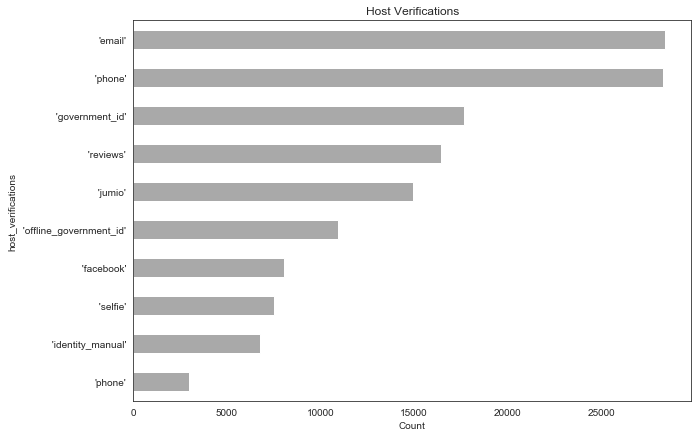

In [102]:
sub_df2 = pd.DataFrame(results2.most_common(10), columns=['host_verifications', 'count'])
sub_df2.sort_values(by=['count'], ascending=True).plot(kind='barh', x='host_verifications', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Host Verifications')
plt.xlabel('Count');

In [103]:
listings['email'] = listings['host_verifications'].str.contains('email')
listings['phone'] = listings['host_verifications'].str.contains('phone')
listings['jumio'] = listings['host_verifications'].str.contains('jumio')
listings['government_id'] = listings['host_verifications'].str.contains('offline_government_id')
listings['government_id'] = listings['host_verifications'].str.contains('government_id')

In [104]:
listings.head(2)

,host_has_profile_pic,host_identity_verified,host_id,host_verifications,require_guest_phone_verification,require_guest_profile_picture,instant_bookable,neighbourhood_cleansed,latitude,longitude,...,Laptop_friendly_workspace,TV,Family_kid_friendly,Smoking_allowed,Air_conditioning,Parking,email,phone,jumio,government_id
0,t,t,68997,"['email', 'phone', 'reviews', 'jumio', 'offlin...",f,f,t,Copacabana,-22.96592,-43.17896,...,True,True,True,True,True,False,True,True,True,True
1,t,t,81163,"['email', 'phone', 'reviews', 'kba']",f,f,f,Ipanema,-22.98467,-43.19611,...,True,True,False,False,True,False,True,True,False,False


__Exploratory Data Analysis (EDA)__


__Step 8:__

Text(0.5, 1.0, 'Distribuicao de preco pelas localidades (latitudexlongitude)')

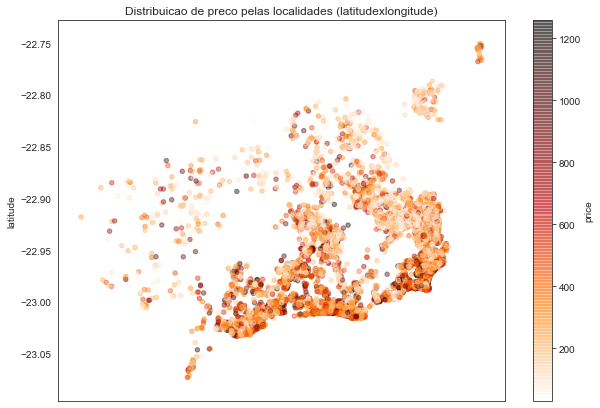

In [105]:
listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True)

plt.title('Distribuicao de preco pelas localidades (latitudexlongitude)')

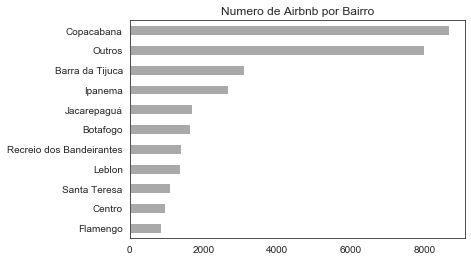

In [106]:
listings['New_nei'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Numero de Airbnb por Bairro');

Text(0.5, 1.0, 'Densidade e distribuicao de precos por bairros')

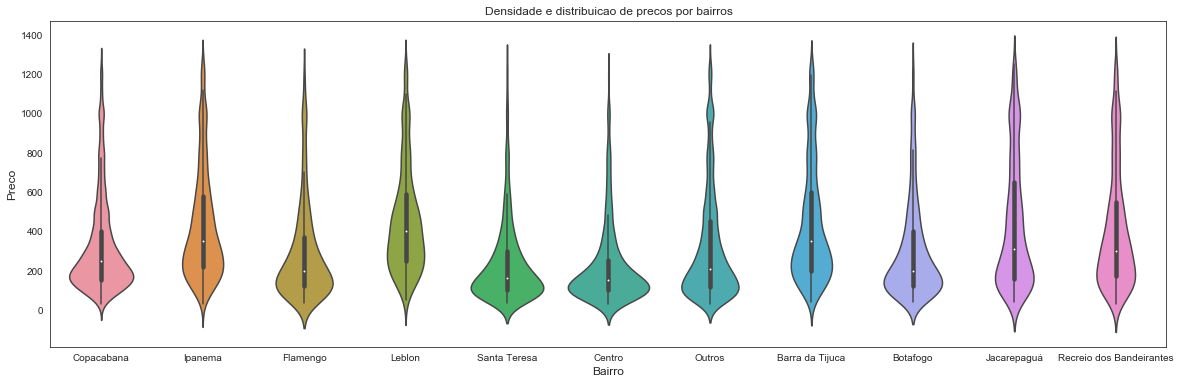

In [107]:
plt.figure(figsize=(20,6))
viz_2=sns.violinplot(data=listings, x='New_nei', y='price')
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preco', fontsize=12)
viz_2.set_title('Densidade e distribuicao de precos por bairros')

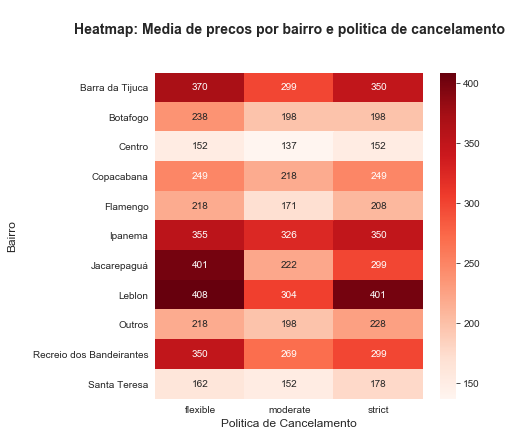

In [108]:
plt.figure(figsize=(6,6))
sns.heatmap(listings.groupby(['New_nei', 'cancellation_policy']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('Politica de Cancelamento', fontsize=12)
plt.ylabel('Bairro\n', fontsize=12)
plt.title('\nHeatmap: Media de precos por bairro e politica de cancelamento\n\n', fontsize=14, fontweight='bold');

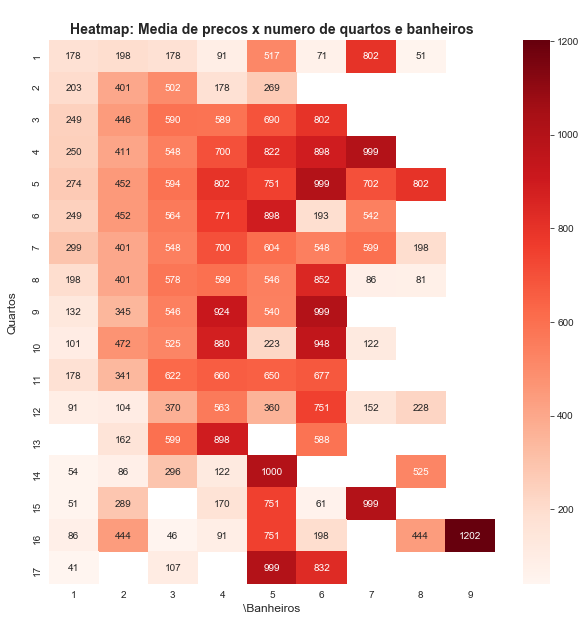

In [109]:
plt.figure(figsize=(10,10))
sns.heatmap(listings.groupby(['beds', 'bathrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\Banheiros', fontsize=12)
plt.ylabel('Quartos\n', fontsize=12)
plt.title('\nHeatmap: Media de precos x numero de quartos e banheiros', fontsize=14, fontweight='bold');

In [176]:
df=listings.copy()

In [177]:
df['host_identity_verified']=df['host_identity_verified'].replace(np.nan,0)
df['host_identity_verified']=df['host_identity_verified'].replace('f',0)
df['host_identity_verified']=df['host_identity_verified'].replace('t',1)
df['instant_bookable']=df['instant_bookable'].replace('f',0)
df['instant_bookable']=df['instant_bookable'].replace('t',1)
df['Laptop_friendly_workspace']=df['Laptop_friendly_workspace'].replace(False,0)
df['Laptop_friendly_workspace']=df['Laptop_friendly_workspace'].replace(True,1)
df['TV']=df['TV'].replace(False,0)
df['TV']=df['TV'].replace(True,1)
df['Family_kid_friendly']=df['Family_kid_friendly'].replace(False,0)
df['Family_kid_friendly']=df['Family_kid_friendly'].replace(True,1)
df['Smoking_allowed']=df['Smoking_allowed'].replace(False,0)
df['Smoking_allowed']=df['Smoking_allowed'].replace(True,1)
df['Air_conditioning']=df['Air_conditioning'].replace(False,0)
df['Air_conditioning']=df['Air_conditioning'].replace(True,1)
df['Parking']=df['Parking'].replace(False,0)
df['Parking']=df['Parking'].replace(True,1)
df['email']=df['email'].replace(False,0)
df['email']=df['email'].replace(True,1)
df['phone']=df['phone'].replace(False,0)
df['phone']=df['phone'].replace(True,1)
df['jumio']=df['jumio'].replace(False,0)
df['jumio']=df['jumio'].replace(True,1)
df['government_id']=df['government_id'].replace(False,0)
df['government_id']=df['government_id'].replace(True,1)
df.head()

,host_has_profile_pic,host_identity_verified,host_id,host_verifications,require_guest_phone_verification,require_guest_profile_picture,instant_bookable,neighbourhood_cleansed,latitude,longitude,...,Laptop_friendly_workspace,TV,Family_kid_friendly,Smoking_allowed,Air_conditioning,Parking,email,phone,jumio,government_id
0,t,1,68997,"['email', 'phone', 'reviews', 'jumio', 'offlin...",f,f,1,Copacabana,-22.96592,-43.17896,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1,t,1,81163,"['email', 'phone', 'reviews', 'kba']",f,f,0,Ipanema,-22.98467,-43.19611,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,t,1,102840,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,0,Copacabana,-22.97712,-43.19045,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
3,t,1,135635,"['email', 'phone', 'manual_online', 'facebook'...",f,f,1,Ipanema,-22.98302,-43.21427,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,t,1,153232,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,0,Ipanema,-22.98816,-43.19359,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [178]:
dummies=[
   'New_nei','cancellation_policy','room_type','property_type']
dummies=pd.get_dummies(df[dummies], drop_first=True)
dummies.shape
dummies.head()

,New_nei_Botafogo,New_nei_Centro,New_nei_Copacabana,New_nei_Flamengo,New_nei_Ipanema,New_nei_Jacarepaguá,New_nei_Leblon,New_nei_Outros,New_nei_Recreio dos Bandeirantes,New_nei_Santa Teresa,...,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
df=df.drop(['New_nei','host_has_profile_pic','host_identity_verified','host_id','require_guest_phone_verification',
            'host_verifications','require_guest_profile_picture','instant_bookable',
           'neighbourhood_cleansed','bed_type','property_type','amenities','room_type',
            'latitude','longitude','cancellation_policy','price_x','square_feet',
           ],axis=1)



In [187]:
df=pd.concat([df, dummies],axis=1)
df.head()

,price,minimum_nights,maximum_nights,guests_included,extra_people,bathrooms,beds,bedrooms,accommodates,bed_type_n,...,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt
0,289.0,5,30,2,73.0,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,406.0,5,30,6,0.0,2,4,2,6,1,...,0,0,0,0,0,0,0,0,0,0
2,162.0,7,60,2,45.0,1,2,1,2,1,...,0,0,0,0,0,0,0,0,0,0
3,330.0,2,1125,2,51.0,1,1,1,3,1,...,0,0,0,0,0,0,0,0,0,0
4,457.0,2,89,2,76.0,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0


In [181]:
df.head()
df.shape
y=df['price']
y.head()
y.shape
X=df.drop(['price'],axis=1)


In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

__Feature Selection__

In [193]:
correlated_features = set()
correlation_matrix =X_train.corr(method ='spearman')
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

set()


In [194]:
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [195]:
mi = mutual_info_regression(X_train, y_train)
mi_df = pd.DataFrame(mi, index = X_train.columns, columns = ['mutual_information'])

In [196]:
mi_top_features = mi_df.sort_values(by = 'mutual_information', ascending=False).head(20)
mi_top_features

,mutual_information
bedrooms,0.151353
extra_people,0.114455
bathrooms,0.096215
room_type_Private room,0.081445
beds,0.078293
guests_included,0.065921
minimum_nights,0.057245
Parking,0.041103
Air_conditioning,0.040519
maximum_nights,0.033879


In [197]:
alpha = [0.1,0.15,0.2, 0.25, 0.275, 0.3, 0.325, 0.35]
a = np.zeros(shape=(len(X_train.columns),len(alpha)))
lasso_feature_coef_df = pd.DataFrame(a,columns=alpha,index=X_train.columns)
lasso_feature_coef_df

for a in alpha: 
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    
    lasso_feature_coef_df[a] = lasso.coef_


In [198]:
lasso_top_features=lasso_feature_coef_df.sort_values(by = alpha, ascending=False).head(20)
lasso_top_features

,0.100,0.150,0.200,0.250,0.275,0.300,0.325,0.350
property_type_Hotel,117.375671,98.139420,80.241258,62.831108,54.062843,45.397037,37.008337,28.619655
bedrooms,84.069798,84.118385,84.193231,84.334647,84.402203,84.463478,84.523533,84.583542
bathrooms,52.617217,52.400029,52.165412,51.955661,51.857924,51.793310,51.737241,51.681186
Parking,46.962674,47.805538,48.649863,49.458710,49.855478,50.209587,50.539477,50.869929
New_nei_Leblon,44.851920,45.736842,46.628525,47.635655,48.231894,48.831796,49.428228,50.026161
Family_kid_friendly,40.931332,40.887801,40.826448,40.764562,40.716648,40.677963,40.644792,40.611632
property_type_Apartment,39.356728,35.606109,33.210959,31.315292,30.274825,29.329265,28.647648,27.965997
New_nei_Ipanema,29.716250,31.170332,32.635411,34.215897,35.089776,35.973256,36.853082,37.734463
Air_conditioning,27.780243,27.860128,27.933151,28.035081,28.099313,28.178989,28.252435,28.325910
property_type_House,19.591017,15.286600,12.304411,9.587416,8.128829,6.715342,5.547992,4.380675


In [199]:
ridge = RidgeCV()
ridge.fit(X_train,y_train)
print("Best score using built-in LassoCV: %f" %ridge.score(X_train,y_train))
a=pd.Series(ridge.coef_, index = X_train.columns).index[:20]
a

Best score using built-in LassoCV: 0.323884


Index(['minimum_nights', 'maximum_nights', 'guests_included', 'extra_people',
       'bathrooms', 'beds', 'bedrooms', 'bed_type_n',
       'Laptop_friendly_workspace', 'TV', 'Family_kid_friendly',
       'Smoking_allowed', 'Air_conditioning', 'Parking', 'email', 'phone',
       'jumio', 'New_nei_Botafogo', 'New_nei_Centro', 'New_nei_Copacabana'],
      dtype='object')

In [200]:
selected_features_lasso = lasso_top_features.index[:20].tolist()
selected_features_mi=mi_top_features.index[:20].tolist()
selected_features_ridge=pd.Series(ridge.coef_, index = X_train.columns).index[:20].tolist()
selected_features= set(selected_features_mi+selected_features_lasso+selected_features_ridge)
selected_features

{'Air_conditioning',
 'Family_kid_friendly',
 'Laptop_friendly_workspace',
 'New_nei_Botafogo',
 'New_nei_Centro',
 'New_nei_Copacabana',
 'New_nei_Ipanema',
 'New_nei_Jacarepaguá',
 'New_nei_Leblon',
 'New_nei_Outros',
 'Parking',
 'Smoking_allowed',
 'TV',
 'bathrooms',
 'bed_type_n',
 'bedrooms',
 'beds',
 'cancellation_policy_strict',
 'email',
 'extra_people',
 'guests_included',
 'jumio',
 'maximum_nights',
 'minimum_nights',
 'phone',
 'property_type_Apartment',
 'property_type_Barn',
 'property_type_Boat',
 'property_type_Boutique hotel',
 'property_type_Hotel',
 'property_type_House',
 'property_type_Loft',
 'property_type_Other',
 'property_type_Serviced apartment',
 'property_type_Tent',
 'room_type_Private room',
 'room_type_Shared room'}

__Modelagem__

In [202]:
X_train=X_train[selected_features]
X_test=X_test[selected_features]

In [203]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(model_gb.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(model_gb.score(X_test, y_test)))

Accuracy score (training): 0.437
Accuracy score (validation): 0.406


In [204]:
min_max1 = MinMaxScaler().fit(X_train)
min_max1_X_train = min_max1.transform(X_train)
min_max1_X_test = min_max1.transform(X_test)
model_min_max1 = GradientBoostingRegressor().fit(min_max1_X_train, y_train)
model_min_max1.score(min_max1_X_test, y_test)

0.40608103534603046

In [205]:
scaler = StandardScaler().fit(X_train)
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)
model_scaler = GradientBoostingRegressor().fit(scaler_X_train, y_train)
model_scaler.score(scaler_X_test, y_test)

0.40640096247156055

In [206]:
robust = RobustScaler().fit(X_train)
robust_X_train = robust.transform(X_train)
robust_X_test = robust.transform(X_test)
model_robust = GradientBoostingRegressor().fit(robust_X_train, y_train)
print(model_robust.score(robust_X_train, y_train))
print(model_robust.score(robust_X_test, y_test))

0.4366270712959953
0.4063954879072672


In [207]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model_gb = GradientBoostingRegressor(learning_rate=learning_rate)
    model_gb.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model_gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model_gb.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.410
Accuracy score (validation): 0.384
Learning rate:  0.075
Accuracy score (training): 0.427
Accuracy score (validation): 0.398
Learning rate:  0.1
Accuracy score (training): 0.437
Accuracy score (validation): 0.406
Learning rate:  0.25
Accuracy score (training): 0.464
Accuracy score (validation): 0.422
Learning rate:  0.5
Accuracy score (training): 0.486
Accuracy score (validation): 0.422
Learning rate:  0.75
Accuracy score (training): 0.496
Accuracy score (validation): 0.414
Learning rate:  1
Accuracy score (training): 0.500
Accuracy score (validation): 0.398


['bedrooms', 0.4685473028858248]
['extra_people', 0.193124759043396]
['minimum_nights', 0.07730691249037583]
['bathrooms', 0.05203853693445648]
['room_type_Private room', 0.031270414589235185]
['maximum_nights', 0.030133274672464776]
['guests_included', 0.016662788101777796]
['beds', 0.014265383680806543]
['Parking', 0.012987920888724233]
['Family_kid_friendly', 0.010785386469930304]
['New_nei_Ipanema', 0.008343171871977547]
['New_nei_Leblon', 0.008115571271137632]
['jumio', 0.008114187939251324]
['room_type_Shared room', 0.007129232267555302]
['Air_conditioning', 0.007032230695013367]
['Laptop_friendly_workspace', 0.006282135849417793]
['property_type_Apartment', 0.005710852318912003]
['New_nei_Copacabana', 0.005513359017403757]
['TV', 0.004968349380755733]
['New_nei_Jacarepaguá', 0.004941685630668738]
['Smoking_allowed', 0.004015830291041651]
['New_nei_Outros', 0.0031655878005639147]
['phone', 0.0028526507928281074]
['property_type_House', 0.002828644298279866]
['email', 0.0025909673

<BarContainer object of 37 artists>

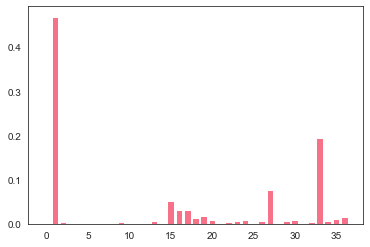

In [208]:
sorted_idx = np.argsort(model_gb.feature_importances_)[::-1]
for index in sorted_idx:
    a=([X_train.columns[index], model_gb.feature_importances_[index]]) 
    print(a)
plt.bar(range(len(model_gb.feature_importances_)), model_gb.feature_importances_ )